In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rcParams['figure.figsize'] = [4,3]

from PIL import Image
import networkx as nx

## Planning Architecture

### Non-deterministic Filter
At time step $t$, given estimates of bounding boxes of obstacles, we have:
$\hat{\mathcal X_t}$ = estimate of the occupied space in the environment.

With estimate from the previous time step, update the estimate as: 
$\bar{\mathcal X_t}=\bar{\mathcal X}_{t-1}\cap\hat{\mathcal X_t}$

In [3]:
def box_to_occ_space(*args):
    # converts bounding box coordinates to occupied spaces
    # use: box_to_occ_space(x_1, x_2, ..., x_n)
    # args x_i: 2xd array of corner coords [[corners1_pred],[corners2_pred]] = [[x,y,z]_min,[x,y,z]_max] (for 3D)
    # return x: nx2xd array of n sets of bounding box coordinates [x_1; x_2; ...; x_n]   
    return np.array(args)

In [4]:
A1x = 0.1;A1y = 0.1;A1z = 0.1;A2x=0.2;A2y=0.2;A2z=0.2
B1x = 0.3;B1y = 0.3;B1z = 0.3;B2x=0.4;B2y=0.8;B2z=0.8
C1x = 0.35;C1y = 0.6;C1z = 0.6;C2x=0.45;C2y=0.7;C2z=0.7
D1x = 0.15;D1y = 0.15;D1z = 0.4;D2x=0.7;D2y=0.5;D2z=0.5
A = np.array([[A1x,A1y],[A2x,A2y]])
B = np.array([[B1x,B1y],[B2x,B2y]])
C = np.array([[C1x,C1y],[C2x,C2y]])
D = np.array([[D1x,D1y],[D2x,D2y]])

occ_space = box_to_occ_space(A,B,C,D)

In [5]:
def visualize_2d(occ_space):
    fig, ax = plt.subplots()
    for i in range(occ_space.shape[0]):
        w = occ_space[i,1,0] - occ_space[i,0,0]
        h = occ_space[i,1,1] - occ_space[i,0,1]
        ax.add_patch(Rectangle(occ_space[i,0,:],w, h, edgecolor = 'k',fc=(0, 0.4470, 0.7410,0.5)))
        # plt.axis('off')
    plt.show()

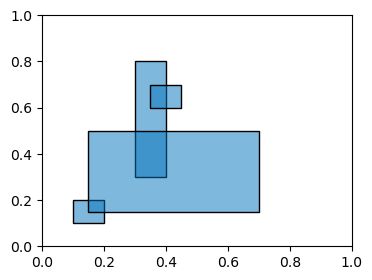

In [6]:
visualize_2d(box_to_occ_space(A,B,C,D))

In [7]:
def overlap(a, b): # 2d implementation
    # returns area of overlap between two rectangles
    # inputs: a, b, rectangles [[xmin, ymin], [xmax, ymax]] (2d)
    # returns: overlapped rectangle, or a, b if no overlap

    ab1x = max(a[0,0], b[0,0])
    ab1y = max(a[0,1], b[0,1])

    dx = min(a[1,0], b[1,0]) - ab1x
    dy = min(a[1,1], b[1,1]) - ab1y
    if (dx>=0) and (dy>=0):
        return np.array([[[ab1x, ab1y], [ab1x+dx, ab1y+dy]]])
    else:
        # return np.array([a, b])
        return None

def non_det_filter(xbar_prev, xhat_now):
    # implements non-deterministic filter
    # inputs: xbar_prev, xhat_now
    # xbar_prev: previous estimate of occ_space
    # xhat_now: current estimate of occ_space
    
    # output: xbar_now, updated estimate of occ_space
    ab_all = []
    for a in xbar_prev:
        for b in xhat_now:
            # print(ab)
            ab = overlap(a, b)
            if (np.any(np.all(a == ab))) or (np.any(np.all(b == ab))) or (ab is None):
                continue
            else:
                ab_all.append(ab)
    xbar_now = np.concatenate(ab_all)
    return xbar_now

In [8]:
xbar_prev = box_to_occ_space(A, B)
xhat_now = box_to_occ_space(C, D)
xbar_now = non_det_filter(xbar_prev, xhat_now)

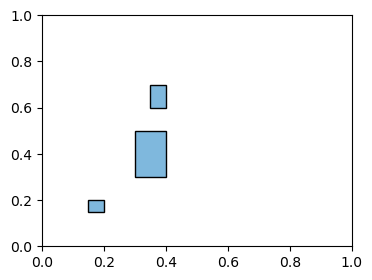

In [9]:
visualize_2d(xbar_now)
# is this what we want..?

### Planning
Plan path to goal for time step $t$, ensuring that we do not enter the ICS at time step $t+1$.
- Simple planning (FMT*) if there is a collision free path to goal
- Optimistic plan if there is no collision free path to goal (?)
    - Replan at next time step
        - Brake if no more plan

- Choice of U: all unobserved space is free space (implemented in our filter)
- Choice of ICS: figure out on Go1
- Choice of intermediate goal: implement or just long-term goal -> no need to use
- Choice of solver: FMT*

### Planning
Plan path to goal for time step $t$, ensuring that we do not enter the ICS at time step $t+1$.
- Inputs
    - `occ_space`: nx2xd array of bounding boxes of obstacles
        - n = # of boxes
        - 2 = corner_min, corner_max
        - d = 2d or 3d (only 2d implementation for now)
    - `start`: [x,y] of current location
    - `goal`: [x,y] of goal location
- Outputs
    - `path_info`: if exist, in order
        - collision-free path to goal
        - path to goal with no collision at next time step
        - brake

In [10]:
from fmt.fmt import FMTPlanner


In [11]:
def occ_to_map(occ_space, w, h, dx):
    # converts rectangle coordinates to map
    # inputs:
        # occ_space: nx2xd array of bounding box coordinates
        # w: width of map
        # h: height of map
        # dx: resolution of map
    # outputs:
        # map: wxh array of map, 0=obstacle, 1=free
    
    # initialize map
    map = np.ones((int(np.ceil(w/dx)),int(np.ceil(h/dx))))

    # iterate through bounding boxes
    for i in range(occ_space.shape[0]):
        # get bounding box
        box = occ_space[i,:,:]
        
        # get min and max indices
        x_min = int(np.floor(box[0,0]/dx))
        x_max = int(np.ceil(box[1,0]/dx))
        y_min = int(np.floor(box[0,1]/dx))
        y_max = int(np.ceil(box[1,1]/dx))
        
        # update map
        map[x_min:x_max,y_min:y_max] = 0

    return map

In [12]:
def ICS(occ_space, brake_dist):
    # dependent on dynamics
    # returns new occupancy space with ICS included
    
    occ_ics = np.zeros(occ_space.shape)
    # iterate through bounding boxes
    for i in range(occ_space.shape[0]):
        # get bounding box
        box = occ_space[i,:,:]
        box_ics =np.vstack((box[0,:] - brake_dist, box[1,:] + brake_dist))
        occ_ics[i,:,:] = box_ics
    return occ_ics

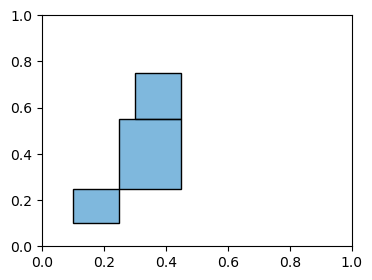

In [15]:
visualize_2d(ICS(xbar_now,0.05))

In [16]:
def visualize_result(map_design: np.ndarray, planner: FMTPlanner,
                     path_info: dict) -> None:
    plt.figure()
    plt.imshow(map_design, cmap="gray")
    nx.draw_networkx(planner.graph, [x[::-1] for x in planner.node_list],
            node_size=1,
            alpha=.5,
            with_labels=False)
    path = path_info["path"]
    plt.plot(path[:, 1], path[:, 0], 'r-', lw=2)

In [17]:
def goal_inter(occ_space, planner, start, goal, radius):
    """Returns best intermediate goal to explore"""
    frontier = [] # list of [x_start, y_start, x_end, y_end]
    candidates = [] # list of segment midpoints
    for subgoal in candidates:
        cost_to_come = planner.plan(start, subgoal)['cost']
        cost_to_go = planner.plan(subgoal, goal)['cost']

In [19]:

occ_ics = ICS(xbar_now,0.05) # add ICS
map_design = occ_to_map(occ_ics,1,1,0.01) # convert to map

In [20]:
def plan(map_design, start, goal):
    """
    safe path: collision free, never enters ICS
    Returns a safe path to goal if there exists one
    Returns a safe path to intermediate goal if there is no direct path to goal
    """
    planner = FMTPlanner(map_design, n_samples=1000, r_n=20, path_resolution=0.1, rr=1.0, max_search_iter=10000)
    path_info = planner.plan(start, goal) # plan collision-free path to goal
    if path_info['goal_flag'] == 0:
        path_temp = planner.plan(start, goal, optimistic = True) # plan path to goal with no collision at t+1
        # TODO: collision check at t+1 -> next node is lowest-cost, collision-free?
        if path_temp['goal_flag'] == 0:
            # TODO: check if goal flag is always 0 -> ignore future collision, should reach goal
            return 'brake'
        else:
            visualize_result(map_design, planner, path_temp)
            return path_temp
            

    else:
        visualize_result(map_design, planner, path_info)
        return path_info['path']

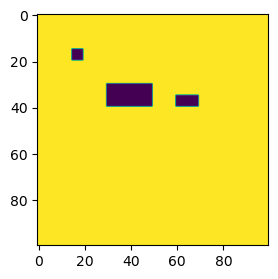

In [21]:
plt.imshow(occ_to_map(xbar_now,1,1,0.01))

[array([54.88135039, 71.51893664]), array([60.27633761, 54.4883183 ]), array([43.75872113, 89.17730008]), array([96.36627605, 38.34415188]), array([79.17250381, 52.88949198]), array([56.80445611, 92.55966383]), array([7.10360582, 8.71292997]), array([ 2.02183974, 83.26198455]), array([77.81567509, 87.00121482]), array([97.86183422, 79.91585642]), array([46.14793623, 78.05291763]), array([11.82744259, 63.99210213]), array([14.33532874, 94.4668917 ]), array([52.18483218, 41.466194  ]), array([26.45556121, 77.42336894]), array([45.61503322, 56.84339489]), array([ 1.87898004, 61.76354971]), array([61.20957227, 61.69339969]), array([94.37480785, 68.18202991]), array([69.76311959,  6.02254716]), array([66.67667154, 67.06378696]), array([57.01967704, 43.86015135]), array([98.83738381, 10.20448107]), array([65.31083255, 25.32916025]), array([46.63107729, 24.4425592 ]), array([65.63295895, 13.81829513]), array([19.65823617, 36.87251707]), array([82.09932298,  9.71012758]), array([83.79449075,  

array([[  0.        ,   0.        ],
       [ 18.61301663,   0.92479942],
       [ 33.30720345,   9.97329472],
       [ 46.63107729,  24.4425592 ],
       [ 53.49168549,  40.42436179],
       [ 67.25823113,  52.8939929 ],
       [ 82.24067384,  65.34211611],
       [ 92.60265066,  81.80772252],
       [100.        , 100.        ]])

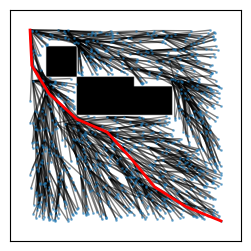

In [23]:
plan(map_design,[0,0],[100,100])